In [130]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')


In [131]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm

import plotly.graph_objects as go
from plotly.offline import iplot
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [132]:
data = pd.read_csv('MSFT.csv',index_col=0)
data.head()

,ds,Open,High,Low,Close,Volume
0,2019-09-13,137.78,138.06,136.57,137.32,16554185.0
1,2019-09-12,137.85,138.42,136.87,137.52,25750600.0
2,2019-09-11,135.91,136.27,135.09,136.12,24726100.0
3,2019-09-10,136.80,136.89,134.51,136.08,28903400.0
4,2019-09-09,139.59,139.75,136.46,137.52,25773900.0


In [133]:
train_len = 600
df = data.loc[:train_len-1].sort_values('ds',ascending=True)
df.shape

(600, 6)

In [134]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.010696
1,0.013268
2,0.026131
3,0.024641
4,0.021663


In [135]:
simulation_size = 10
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
test_size = 15
learning_rate = 0.05

df_train = df_log
df.shape, df_train.shape

((600, 6), (600, 1))

In [93]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [94]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [95]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

W0915 03:58:28.433508 4518725056 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x1a2f79a240>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1


train loop: 100%|██████████| 300/300 [03:19<00:00,  1.50it/s, acc=97.3, cost=0.00169]
W0915 04:01:49.012810 4518725056 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x1a36b1a4a8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2


train loop: 100%|██████████| 300/300 [03:22<00:00,  1.48it/s, acc=97, cost=0.00223]
W0915 04:05:13.027494 4518725056 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x1a36034978>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3


train loop: 100%|██████████| 300/300 [03:20<00:00,  1.49it/s, acc=97.6, cost=0.00139]
W0915 04:08:34.611974 4518725056 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x1a2f4ac780>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4


train loop: 100%|██████████| 300/300 [03:21<00:00,  1.49it/s, acc=96.9, cost=0.00277]
W0915 04:11:57.026589 4518725056 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x1a37654fd0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5


train loop: 100%|██████████| 300/300 [03:21<00:00,  1.49it/s, acc=97.2, cost=0.00199]
W0915 04:15:19.418098 4518725056 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x1a37e0e710>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 6


train loop: 100%|██████████| 300/300 [03:29<00:00,  1.43it/s, acc=97.2, cost=0.00181]
W0915 04:18:49.764404 4518725056 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x1a38167cc0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 7


train loop: 100%|██████████| 300/300 [03:11<00:00,  1.57it/s, acc=97.1, cost=0.002]
W0915 04:22:01.700525 4518725056 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x1a38e11f28>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 8


train loop: 100%|██████████| 300/300 [03:27<00:00,  1.45it/s, acc=96.4, cost=0.00311]
W0915 04:25:29.935304 4518725056 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x1a395814a8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 9


train loop: 100%|██████████| 300/300 [03:19<00:00,  1.50it/s, acc=97.5, cost=0.00149]
W0915 04:28:50.272828 4518725056 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x1a39a69dd8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 10


train loop: 100%|██████████| 300/300 [03:18<00:00,  1.51it/s, acc=96.6, cost=0.00322]


In [96]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

9

In [97]:
accepted_results = results

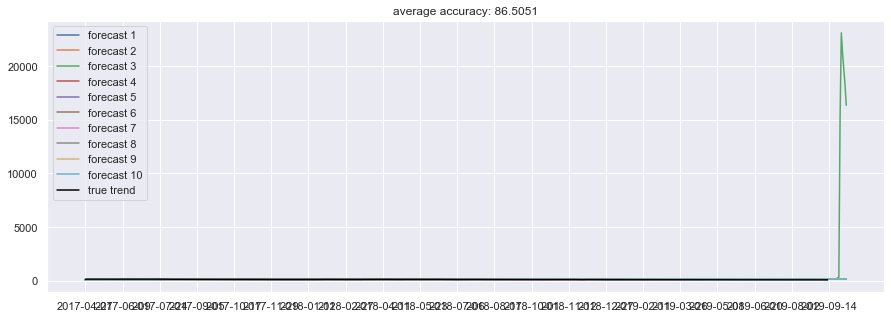

In [98]:
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'], label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::30], date_ori[::30])

plt.show()

In [99]:
accuracies

[86.68171592395514,
 88.35596403756476,
 87.70280783403808,
 88.63910493170489,
 90.64949093914029,
 86.39944742252972,
 88.24332482511579,
 76.01826032308072,
 95.62333137627888,
 76.73782695977921]

In [100]:
data.loc[train_len+1:train_len+test_size].shape

(15, 6)

In [104]:
traces = []
actuals = data.loc[train_len+1:train_len+test_size]['Close'].values
indexs = data.loc[train_len+1:train_len+test_size]['Close'].index
tr_actuals = go.Scatter(x=indexs,y=data.loc[train_len:train_len+test_size]['Close'].values,name='actuals')
traces.append(tr_actuals)
for i,r in enumerate(accepted_results):
    preds = r[train_len:train_len+test_size]
    tr_preds = go.Scatter(x=indexs,y=preds,name=f'preds-{i}')
    traces.append(tr_preds)

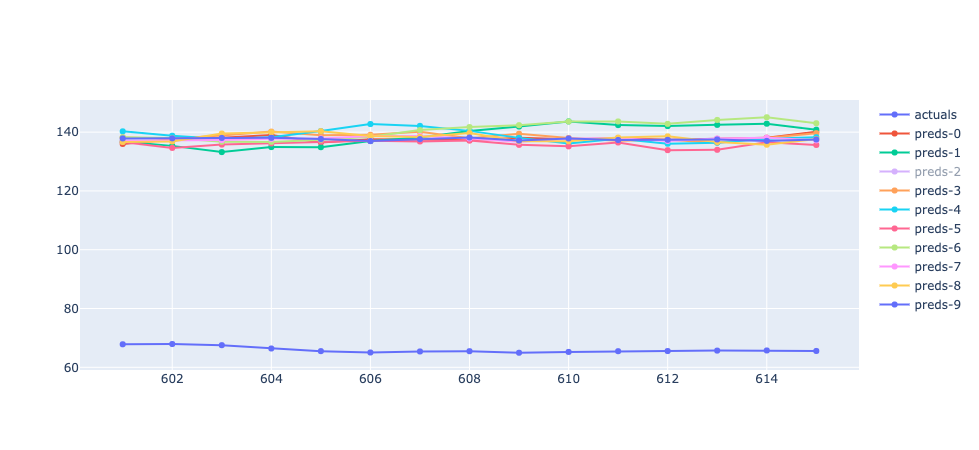

In [105]:
iplot(traces)

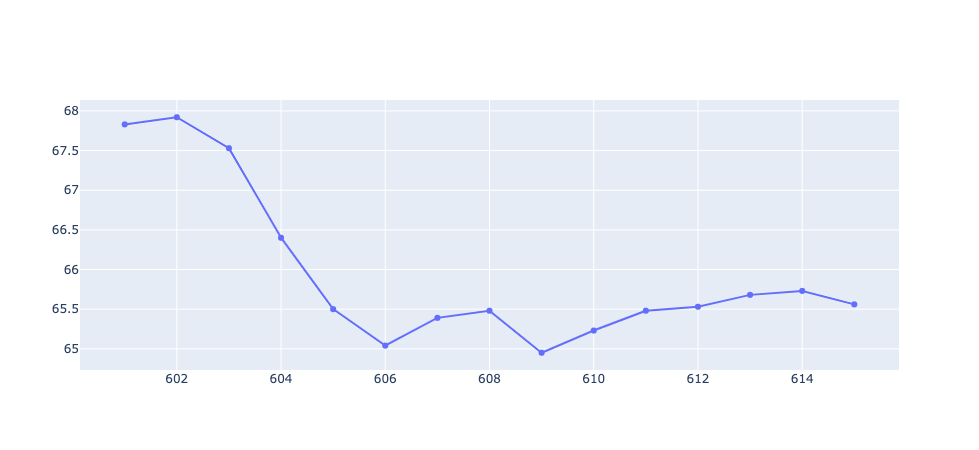

In [106]:
iplot([tr_actuals])